# Systematically Pricing Financial Options With Black Scholes

## 1. The Data

To calculate our potential payoffs from the option, we need the historical data of the stock’s price for one year (in this case, Dec 27, 2019 - Dec 27, 2020) and data on the price level that the options are currently being traded at so we can compare our results.

The historical data can be obtained from Yahoo Finance: go to Historical Data and download the dataset for one year.

In [1]:
# download annual historical data for the stock
import pandas as pd
df = pd.read_csv("TSLA.csv")
df = df.sort_values(by="Date")
df = df.dropna()

In [2]:
# calculate returns
df = df.assign(close_day_before=df.Close.shift(1))
df['returns'] = ((df.Close - df.close_day_before)/df.close_day_before)


In [3]:
# https://finance.yahoo.com/quote/TSLA/options?p=TSLA&date=1610064000
# get options data from yahoo finance // in this case, exercise data is jan 8th
r = pd.read_html('https://finance.yahoo.com/quote/TSLA/options?p=TSLA&date=1610064000')[0]

ValueError: No tables found

In [7]:
len(r)

93

## 2. The Black-Scholes Formula in Python

Below is the same Black Scholes formula described in the start of the article, but now represented by a Python function named black_scholes . Note that the present value formula of the risk-free bond is just the price of the bond K divided by (1 + risk free rate) to the power of the fraction of time T, and we are using the Python function cdf to calculate the cumulative distribution function value of our variables d1 and d2.

In [4]:
# S is the spot price 
# K is the strike price 
# T is the fraction of days to strike date divided by 252 (stock market days)
# r is the risk free rate
# sigma is the annual volatility of the returns of the stock 

def black_scholes(S, K, T, r, sigma):
    d1 = np.log(S/(K/(1 + r)**T)/(sigma*sqrt(T))) + (sigma*sqrt(T))/2
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - (K/(1 + r)**T) * norm.cdf(d2)

## 3. The Black-Scholes Algorithm

Having calculated the volatility (square root of financial market days times the standard deviation of the annualised returns), we can make estimates for all the strike prices we currently have available contracts for. In Tesla’s case, we have 93 different strike prices for call options.

For each strike price, we input the spot price of the stock (661.77 at the moment), loop through the strike prices in the data frame r, the risk-free rate which I am using the 10-year U.S. treasury yield currently at 0.94%.

In [10]:
from math import sqrt
import numpy as np
from scipy.stats import norm

# Calculate the volatility as the annualized standard deviation of the stock returns
sigma = np.sqrt(252) * df['returns'].std()

list_estimates = []

# currently 35 different strike prices for call contracts 
for x in range(0,93):
    value_s = black_scholes(S = 661.77, 
                            K = r['Strike'][x], 
                            T = (40/252), 
                            r = 0.0094, 
                            sigma = sigma)
    list_estimates.append(value_s)
    

# merge the two lists to compare results
df_list = pd.DataFrame(data=list_estimates, index=r.index)
df_list['estimate_1'] = df_list[0]
del df_list[0]
df_estimate = r.merge(df_list, right_index = True, left_index = True)

In [12]:
df_estimate.head()

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,estimate_1
0,TSLA210108C00350000,2020-12-24 10:53AM EST,350.0,312.00,310.45,313.95,13.45,+4.51%,5,55,144.48%,314.686568
1,TSLA210108C00360000,2020-12-02 10:12AM EST,360.0,208.90,300.50,304.00,0.00,-,-,1,140.63%,305.356586
2,TSLA210108C00370000,2020-12-16 2:05PM EST,370.0,253.79,290.55,294.05,0.00,-,-,8,136.62%,296.088389
3,TSLA210108C00380000,2020-12-23 11:25AM EST,380.0,264.73,280.60,284.10,0.00,-,25,21,132.52%,286.883310
4,TSLA210108C00390000,2020-12-22 12:09PM EST,390.0,246.25,270.65,274.15,0.00,-,3,4,128.37%,277.742578


We output the data frame df_estimate that we can use to calculate how close the Black Scholes model estimates were to the actual price that the options are being traded at in the market:

C:\Users\trivenikuchi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


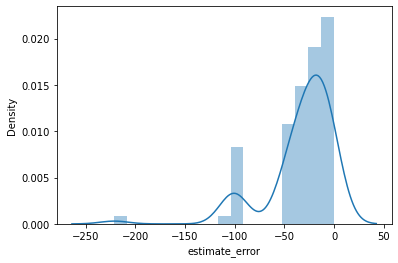

In [16]:
df_estimate['estimate_error'] = ((df_estimate['Ask'] - df_estimate['estimate_1'])/df_estimate['estimate_1'])*100
import seaborn as sns, numpy as np
ax = sns.distplot(df_estimate['estimate_error'])

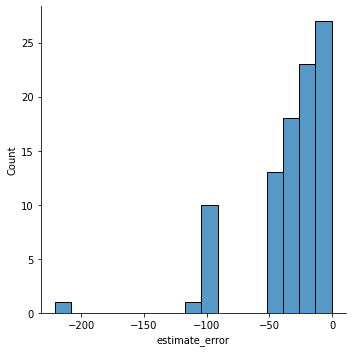

In [19]:
ax = sns.displot(df_estimate['estimate_error'])

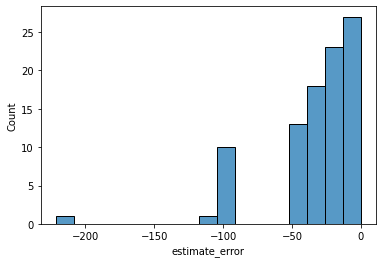

In [20]:
ax = sns.histplot(df_estimate['estimate_error'])

In [17]:

df_estimate['estimate_error'].describe()

count     93.000000
mean     -33.497482
std       35.228107
min     -221.102640
25%      -41.828528
50%      -23.308627
75%      -10.704877
max       -0.234064
Name: estimate_error, dtype: float64

Our mean estimation error is -33.49%, with a standard deviation of 35.228 percentage points. Our median is even more 'weird' at around -23.308%. Our standard deviation still seems a bit high, but looking closer at the dataset we can see that there are a few contracts that haven’t been traded at all today which skews the dataset since these prices aren’t as highly updated.

If we only included contracts that have been traded at least once today:

In [22]:
df1 = df_estimate[(df_estimate.Volume != '-')]

C:\Users\trivenikuchi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


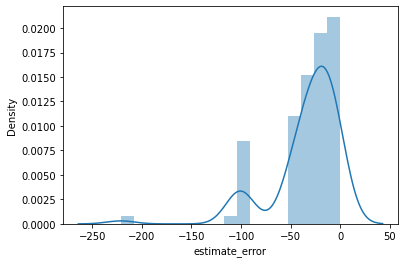

In [23]:
ax = sns.distplot(df1['estimate_error'])

In [24]:
df1['estimate_error'].describe()

count     91.000000
mean     -34.221243
std       35.269939
min     -221.102640
25%      -42.551125
50%      -23.764058
75%      -11.862255
max       -0.234064
Name: estimate_error, dtype: float64

Here we have a mean estimation error of -34.22% which means the options prices are on average underpricing the options by 34.22% compared to our estimates and our standard deviation is 35.26 percentage points.

For curiosity, let’s analyse the few contracts where the black Scholes has made an error larger than 1%:

In [25]:
df1[df1['estimate_error'] > 1]

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,estimate_1,estimate_error


There are none lol